In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import distributions
from scipy.cluster import hierarchy

from classes.dpm import DPM
from classes.variables import Normal, InvGamma

In [2]:
def cluster_means(clusters:np.ndarray, y:np.ndarray) -> np.ndarray:
    r = clusters

    uniques, counts = np.unique(r, return_counts=True)

    means = np.zeros_like(uniques)

    for i, u in enumerate(uniques):
        y_u = y[r == u]
        mean = np.mean(y_u)
        means[i] = mean

    return means

def cluster_weights(clusters:np.ndarray) -> np.ndarray:
    r = clusters

    uniques, counts = np.unique(r, return_counts=True)

    return counts / np.sum(counts)

def init_clusters(y:np.ndarray, H=10):
    assert y.ndim == 1

    Z = hierarchy.linkage(y.reshape(-1,1))
    r = hierarchy.cut_tree(Z, n_clusters=4).squeeze()

    means = cluster_means(r, y)
    weights = cluster_weights(r)

    return means, weights, r, np.repeat(0, H), Z

def reset_clusters_index_to_zero(array_1:np.ndarray) -> np.ndarray:
    array_2 = np.empty_like(array_1)
    unique_in_1 = np.unique(array_1)
    arg_sorted = unique_in_1.argsort()

    for j in arg_sorted:
        array_2[np.where(array_1 == unique_in_1[j])] = arg_sorted[j]

    return array_2   


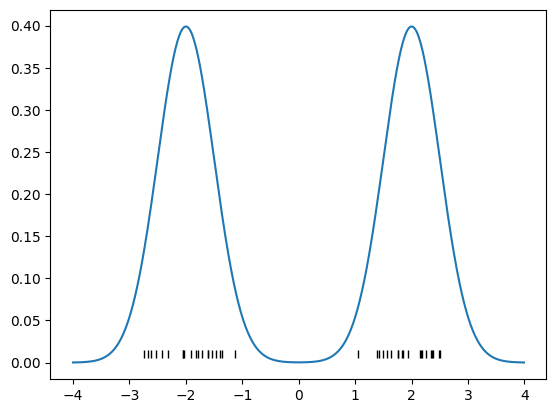

In [3]:
N = 40
w1, w2 = 0.5, 0.5
def f(X, w1=w1) -> np.ndarray:
    return w1*distributions.norm.pdf(X, loc=-2, scale=0.5) + (1-w1)*distributions.norm.pdf(X, loc=2, scale=0.5)

x = np.concatenate((distributions.norm.rvs(loc=-2, scale=0.5, size=20), distributions.norm.rvs(loc=2, scale=0.5, size=20)))
x = np.array([-1.53629916, -1.12899357, -1.60518996, -2.67966081, -1.61694437,
       -2.61227713, -1.82789   , -1.71601606, -2.05882823, -2.41817848,
       -1.77919486, -2.53774749, -2.03994924, -1.91333174, -2.04496604,
       -1.47176651, -2.74409821, -2.30864702, -1.36515045, -1.40199027,
        2.48601161,  1.76388351,  1.48735084,  2.37398349,  2.17628195,
        1.38835878,  2.35179967,  2.25751194,  1.64029622,  2.15503278,
        2.50357713,  1.41946357,  1.75196487,  1.85304607,  2.35279943,
        1.05821439,  2.1743446 ,  1.93528365,  1.82157555,  1.55938066])

plt.plot(x, [0.01]*len(x), '|', color="k")
plt.plot(np.arange(-4, 4, 0.01), f(np.arange(-4, 4, 0.01)))

In [5]:
m, _, r, _, Z = init_clusters(x)

param_list = [[i, 1] for i in m]
print(param_list)


[[-1, 1], [-2, 1], [1, 1], [1, 1]]


In [6]:
dpm = DPM()

dpm.set_measures(param_list)
dpm.set_dataset(x, r)

In [7]:
dpm.sample(200)

step:   40/ 200 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
step:   80/ 200 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
step:  120/ 200 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
step:  160/ 200 : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [8]:
def plot_posterior_density(x, results:dict):
    xmin = np.min(x) - 2
    xmax = np.max(x) + 2

    w = results["w"][:]
    t = results["theta"][:]

    big_X = np.arange(np.min(x)-2, np.max(x)+2, 0.01)

    fig, ax = plt.subplots(1,2, figsize=(12, 6))

    a, b = np.unique(results["n_clusters"], return_counts=True)
    ax[0].bar(x=a, height=b)


    for i in range(len(w)):
        len_w = len(w[i])

        y = []
        mu = np.array(t[i])[:,0]
        sigma = np.array(t[i])[:,1]

        for j in range(len_w):
            y.append(w[i][j] * distributions.norm.pdf(big_X, loc=mu[j], scale=sigma[j]))

            
        y = np.sum(y, axis=0)

        ax[1].plot(big_X, y, color="k", alpha=0.05)

    ax[1].plot(x, [0.01]*len(x), '|', color="k")
    # ax[1].plot(np.arange(xmin, xmax, 0.01), f_data(np.arange(xmin, xmax, 0.01)), color="tab:blue")
    ax[1].plot(np.arange(xmin, xmax, 0.01), f(np.arange(xmin, xmax, 0.01)), linestyle="dashed")
    # ax[1].plot(np.arange(xmin, xmax, 0.01), f2(np.arange(xmin, xmax, 0.01)), color="red", linestyle="dashed")

In [9]:
chain = dpm._dpm_chain
results = {"w": chain.w, "theta": chain.phi, "n_clusters": chain.n}

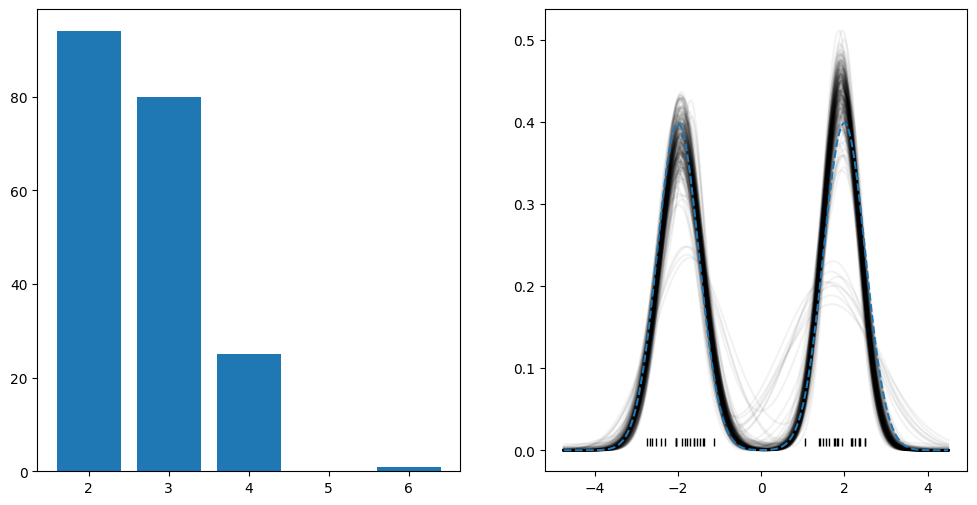

In [10]:
plot_posterior_density(x, results)

In [16]:
param_list = [[i, 1] for i in m]
param_list

[[-1, 1], [-2, 1], [1, 1], [1, 1]]

step:   40/ 200 : [0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
step:   80/ 200 : [2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3]
step:  120/ 200 : [1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 3, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0]
step:  160/ 200 : [1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


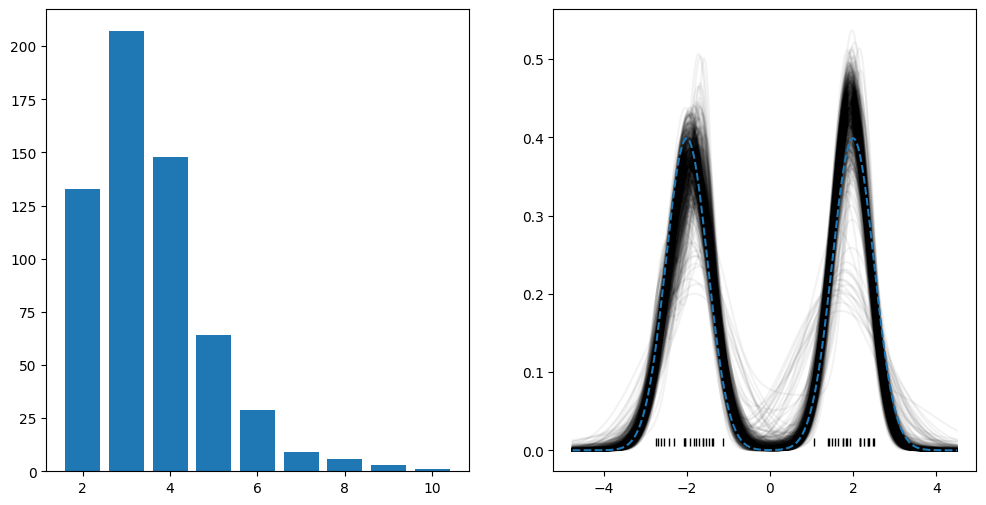

In [17]:
dpm = DPM(M=50)

dpm.set_measures(param_list)
dpm.set_dataset(x, r)
dpm.sample(200)

chain = dpm._dpm_chain
results = {"w": chain.w, "theta": chain.phi, "n_clusters": chain.n}

plot_posterior_density(x, results)

In [18]:
param_list

[[-1, 1], [-2, 1], [1, 1], [1, 1]]

step:   40/ 200 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
step:   80/ 200 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
step:  120/ 200 : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
step:  160/ 200 : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


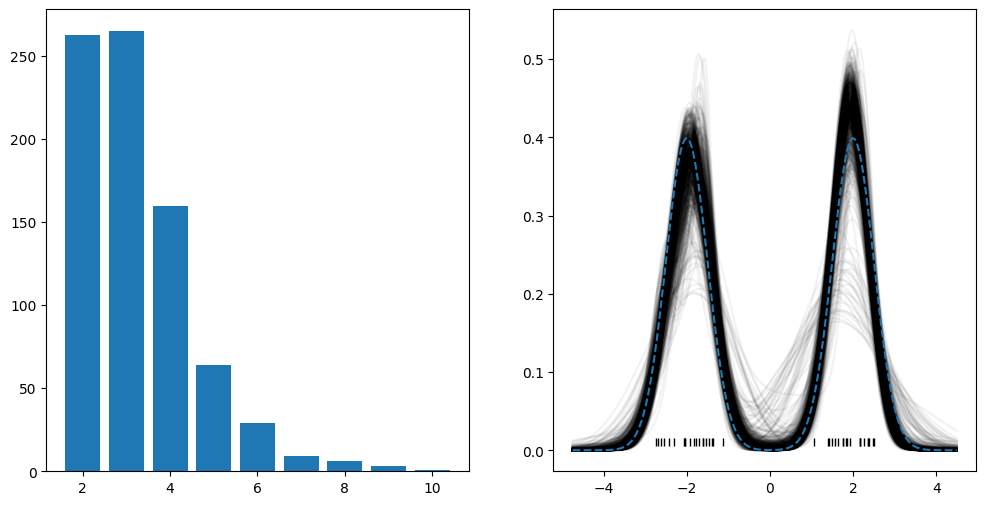

In [21]:

dpm = DPM(M=.5)

dpm.set_measures(param_list)
dpm.set_dataset(x, r)
dpm.sample(200)
plot_posterior_density(x, results)

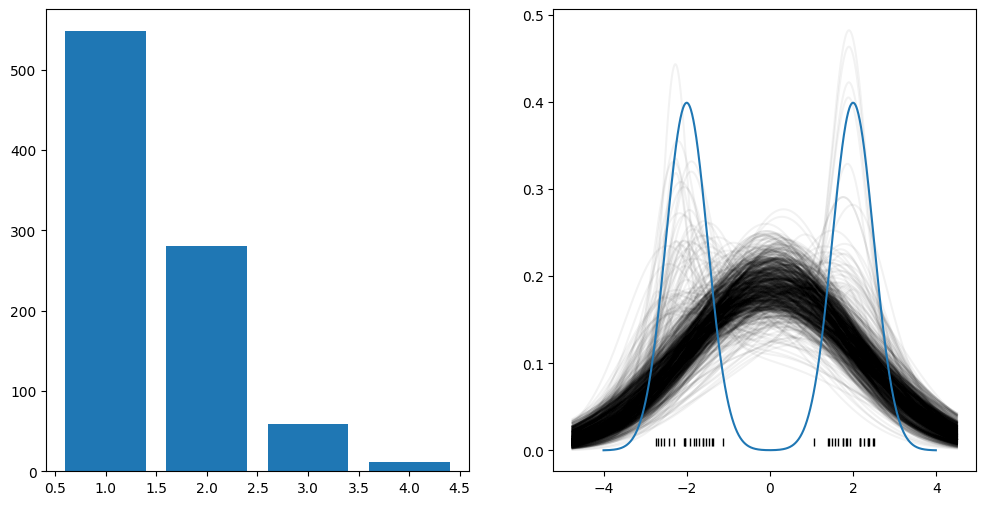

In [ ]:

dpm = DPM([normal, invgamma], M=.1)

dpm.set_parameters(
    # [[Normal(current=-1), InvGamma(current=1)],
    [[Normal(current=0), InvGamma(current=1)],
    # [Normal(current=1), InvGamma(current=1)],
    [Normal(current=2), InvGamma(current=1)]]
)

results = dpm_sampler_7(x, s, dpm, lag=1, mh_steps=1)
plot_posterior_density(x, results)